# Info

**Project**

Assessment of gap-filling techniques applied to satellite phytoplankton composition products for the Atlantic Ocean

**Credit**

**© Ehsan Mehdipour**, 2025. (ehsan.mehdipour@awi.de)

Alfred Wegener Insitute for Polar and Marine Research, Bremerhaven, Germany

This work is licensed under the **GNU General Public License v3.0 (GPL-3.0)**. 

**Objective**

This code read the DINCAE gap-filled and DINEOF gap-filled product and merged the regions using feathering (alpha blending or linear blending). The focus is only the duration of the expedition that we have in-situ measurement for independent validation.

**Dataset**

The dataset is accessable through Copernicus Marine Service with the following DOI:
https://doi.org/10.48670/moi-00280 and Dataset ID: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D

# Setup and configuration

## Import modules

In [4]:
# Modules for data analysis
import os
os.environ["OMP_NUM_THREADS"] = "1"
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import dask
from dask.diagnostics import ProgressBar
from scipy import stats
import dask.array as da

# Modules for data visualisation
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, NullFormatter
import matplotlib.dates as mdates
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker
import string

# Miscellaneous modules
from tqdm import tqdm

# Manual modules or parameters
from function import *
from params import *

## Input and output parameters configuration

In [5]:
# CSV file detailing the boundries of regions of interest (ROI)

regions = pd.read_csv('data/regions.csv', index_col=0)

# Blending

## Original satellite 
Reading the original satellite dataset to create a base to merge the gap-filled product on top.

In [ ]:
## Only reading 2 month of dataset surrounding expedition time 
file_dir = os.path.join(params['output_dir'],'data/20180[5-6]*')
ds = xr.open_mfdataset(file_dir, chunks={'time': 1, 'lat': 'auto', 'lon': 'auto'})

## Extract the expedition duration data
ds = ds.sel(time=slice(params['expedition_start_date'], params['expedition_end_date']))
## Extract PFTs
ds = ds[params['PFT']]

## Create an empty (NaN) dataset as base to merge the gap-filled dataset into it.
data_vars = {}
for pft in params['PFT']:
    shape = (len(ds.time), len(ds.lat), len(ds.lon))
    data_vars[pft] = (('time', 'lat', 'lon'), da.full(shape, np.nan, chunks=ds[pft].chunks))

ds_base = xr.Dataset(
    data_vars=data_vars,
    coords={
        'time': ds.time,
        'lat': ds.lat,
        'lon': ds.lon,
    }
)

## Reading gap-filled dataset

Choose only ONE of the gap-filling method to merge the datasets.

### DINCAE

In [ ]:
experiment='final'
## Read DINCAE gap-filled datasets
ds_regions = {}

## Loop over all the regions to read the dataset accordingly
for region in tqdm(list(regions.index)):
    
    ## Read gap-filled dataset for the region
    ds_filled = xr.open_dataset(os.path.join(params['output_dir'],str(region),'DINCAE','ds_reconstructed.nc'), chunks={'time': -1, 'lat': -1, 'lon': -1})
    
    ## Read the main data to extract dimensions and coordinates
    ds_pft = xr.open_dataset(os.path.join(params['output_dir'],str(region),'ds_pft_dev.nc'))
    ds_filled = ds_filled.assign_coords({'time':ds_pft.time, 'lat':ds_pft.lat, 'lon':ds_pft.lon})
    
    ## Remove boundry effect
    ds_filled = rm_boundry(ds_filled,pixels=5)
    
    ## Extract expedition duration and PFT datasets
    ds_filled = ds_filled[params['PFT']].sel(time=slice(params['expedition_start_date'],params['expedition_end_date']))
    ds_regions[region] = ds_filled

### DINEOF

In [ ]:
experiment='final'

## Read DINEOF gap-filled datasets
ds_regions = {}

## Loop over all the regions to read the dataset accordingly
for region in tqdm(list(regions.index)):
    ## Read gap-filled dataset for the region
    ds_filled = xr.open_mfdataset(os.path.join(output_dir, str(region), 'DINEOF', str(experiment), 'ds_reconstructed_*.nc'))
    
    ## Read the main data to extract dimensions and coordinates
    ds_pft = xr.open_dataset(os.path.join(params['output_dir'],str(region),'ds_pft_dev.nc'))
    ds_filled = ds_filled.rename(
            {'dim003':'time','dim002':'lat','dim001':'lon'}
        ).assign_coords(
            {'time':ds_pft.time, 'lat':ds_pft.lat,'lon':ds_pft.lon}
        )
    ## Remove boundry effect
    ds_filled = rm_boundry(ds_filled,pixels=5)
    
    ## Extract expedition duration and PFT datasets
    ds_filled = ds_filled[params['PFT']].sel(time=slice(params['expedition_start_date'],params['expedition_end_date']))
    ds_regions[region] = ds_filled

## Blending the overlapping regions

In [ ]:
## Remove the extra dataset in the base

lat_max,lat_min,lon_max,lon_min = [],[],[],[]

for region in tqdm(list(regions.index)):
    lat_max.append(ds_regions[region].lat.max().values)
    lat_min.append(ds_regions[region].lat.min().values)
    lon_max.append(ds_regions[region].lon.max().values)
    lon_min.append(ds_regions[region].lon.min().values)
    
lat_max = max(lat_max)
lat_min = min(lat_min)
lon_max = max(lon_max)
lon_min = min(lon_min)

ds_base = ds_base.sel(lat = slice(lat_max,lat_min), lon = slice(lon_min, lon_max))

In [ ]:
## Computing the alpha blending coefficient and mean dataset for each overlapping region

for overlap in tqdm(list(regions.index)[0:-1]):
    # Determine the overlapping region
    ds_filled1 = ds_mean[overlap]
    ds_filled2 = ds_mean[overlap + 1]

    lat_overlap = np.intersect1d(ds_filled1.lat.values, ds_filled2.lat.values)
    lon_overlap = np.intersect1d(ds_filled1.lon.values, ds_filled2.lon.values)

    ## Select the overlapping regions
    ds1_overlap = ds_filled1.sel(lat=lat_overlap, lon=lon_overlap)
    ds2_overlap = ds_filled2.sel(lat=lat_overlap, lon=lon_overlap)

    lat_len = len(ds1_overlap.lat)
    lon_len = len(ds1_overlap.lon)

    ## Create dask arrays for the blending weights
    lat_weights = da.linspace(0, 1, lat_len, chunks=lat_len)
    lon_weights = da.linspace(0, 1, lon_len, chunks=lon_len)
    weights = da.outer(lat_weights, lon_weights)

    weight_array = xr.DataArray(weights, dims=['lat', 'lon'], coords={'lat': ds1_overlap.lat, 'lon': ds1_overlap.lon})

    ## Delayed computation for blended_overlap
    blended_overlap = ds1_overlap * (1 - weight_array) + ds2_overlap * weight_array

    ## Update the datasets with the blended overlap, still delayed
    ds_mean[overlap] = ds_mean[overlap].combine_first(blended_overlap)
    ds_mean[overlap + 1] = ds_mean[overlap + 1].combine_first(blended_overlap)


In [ ]:
## Use xarray's combine_first to combine datasets into empty base

for region in tqdm(list(regions.index)):
    ds_base = ds_base.combine_first(ds_mean[region])

In [ ]:
# SLURM Cluster
# cluster, client = dask_slurm_cluster(queue='smp', cores=16, scale=16)

# Distributed Cluster
# client = dask_distributed_client(n_workers=8, threads_per_worker=None)

In [ ]:
ds_base = ds_base.compute()

In [ ]:
ds_base = ds_base.dropna(dim='lat', how='all').dropna(dim='lon', how='all')

In [ ]:
# ds_base.to_netcdf('/albedo/work/projects/p_phytooptics/emehdipo/PS113/CMEMS/regions/merged/ds_mean_dineof.nc')

## Plot

In [3]:
## Rereading the saved merged data

ds_input = xr.open_dataset(os.path.join(params['output_dir'],'merged/ds_input.nc')).compute()
ds_dineof = 10**(xr.open_dataset(os.path.join(params['output_dir'],'merged/ds_dineof.nc'))).compute()
ds_dincae = 10**(xr.open_dataset(os.path.join(params['output_dir'],'merged/ds_dincae.nc'))).compute()

ds_input = ds_input.where(np.isfinite(ds_dincae)) ## only the extracted regions

In [4]:
# Colorbar boundry

vmin = ds_input.quantile(0.05)
vmax = ds_input.quantile(0.95)

In [6]:
# CSV file detailing the boundries of regions of interest (ROI)

regions = pd.read_csv('data/regions.csv', index_col=0)
## Expedition in-situ locations cluster in different groups using k-means clustering
gdf_clusters = gpd.read_file("clusters/all_clusters.shp")

In [7]:
## Reading shapefile of expedition path

gdf_path = gpd.read_file("clusters/PS113-path.shp")

In [17]:
## Number of EOF extracted for each Area in the final reconstruction
NEOF = {1:55,2:33,3:18,4:45,5:26,6:18,7:16,8:20,9:52,10:32}

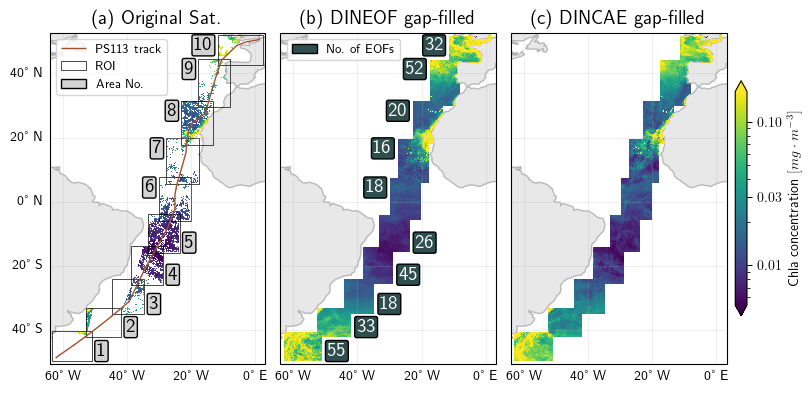

In [46]:
## Date and DataArray considered for ploting
time = '2018-05-26'
pft= 'DIATO'

fig, ax = plt.subplots(1,3, figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True);

ax = ax.flatten()
p_input = (ds_input[pft].sel(time=time)).plot(ax=ax[0], robust=True,add_colorbar=False,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=vmin[pft].values, vmax=vmax[pft].values));
p_dineof = (ds_dineof[pft].sel(time=time)).plot(ax=ax[1], robust=True,add_colorbar=False,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=vmin[pft].values, vmax=vmax[pft].values));
p_dincae = (ds_dincae[pft].sel(time=time)).plot(ax=ax[2], robust=True,add_colorbar=False,transform=ccrs.PlateCarree(), norm=LogNorm(vmin=vmin[pft].values, vmax=vmax[pft].values));

gdf_path.plot(ax=ax[0], label='PS113 track', linewidth=1, color='sienna')

## regions
for idx in range(len(list(regions.index))):
    lon_min = regions.iloc[idx].lon_min
    lon_max = regions.iloc[idx].lon_max

    lat_min = regions.iloc[idx].lat_min
    lat_max = regions.iloc[idx].lat_max

    patch = ax[0].add_patch(Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
             edgecolor = 'k',
             fill=False,
             lw=0.5))
    if idx == 0:
        patch.set_label('ROI')
    
    facecolor = 'lightgrey'
    if idx > 4:
        ax[0].text(x = lon_min-1.5, y = lat_max-0.5, s = f'{idx+1}',c = 'k', horizontalalignment='right', verticalalignment='top', fontsize=14, fontweight='bold',
                  bbox=dict(facecolor=facecolor, alpha=1, edgecolor='black', boxstyle='round',pad=0.1))
    else:
        ax[0].text(x = lon_max+1.5, y = lat_min+0.5, s = f'{idx+1}',c = 'k', horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontweight='bold',
                  bbox=dict(facecolor=facecolor, alpha=1, edgecolor='black', boxstyle='round',pad=0.1))
    proxy1 = Rectangle((0, 0), 1, 1, facecolor=facecolor, edgecolor='black', label="Area No.")

    facecolor = 'darkslategray'
    if idx > 4:
        ax[1].text(x = lon_min-1.5, y = lat_max-0.5, s = f'{NEOF[idx+1]}',c = 'white', horizontalalignment='right', verticalalignment='top', fontsize=14, fontweight='bold',
                  bbox=dict(facecolor=facecolor, alpha=1, edgecolor='black', boxstyle='round',pad=0.1))
    else:
        ax[1].text(x = lon_max+1.5, y = lat_min+0.5, s = f'{NEOF[idx+1]}',c = 'white', horizontalalignment='left', verticalalignment='bottom', fontsize=14, fontweight='bold',
                  bbox=dict(facecolor=facecolor, alpha=1, edgecolor='black', boxstyle='round',pad=0.1))

    proxy2 = Rectangle((0, 0), 1, 1, facecolor=facecolor, edgecolor='black', label="No. of EOFs")



handles, labels = ax[0].get_legend_handles_labels()
handles.append(proxy1)

ax[0].legend(handles= handles, loc = 'upper left', fontsize=9)
ax[1].legend(handles=[proxy2], loc = 'upper left', fontsize=9)
#------------------------------------------

extent = [ds_input.lon.min()-1,
          ds_input.lon.max()+1,
          ds_input.lat.min()+4,
          ds_input.lat.max()-4]

titles = ['(a) Original Sat.', '(b) DINEOF gap-filled', '(c) DINCAE gap-filled']

for i in range(len(ax)):
    ax[i].set_title(titles[i], fontsize=14, fontweight='bold')
    ax[i].add_feature(cartopy.feature.LAND, facecolor='lightgrey', edgecolor='grey', alpha=0.5)
    gl = ax[i].gridlines(draw_labels=True ,alpha=0.2, linestyle='-')
    gl.right_labels = False
    gl.top_labels = False
    ax[i].set_extent(extent)
    gl.xlocator = mticker.FixedLocator([-60,-40,-20,0])
    if i >0:
        gl.left_labels=False
        
    gl.xformatter = mticker.FuncFormatter(lambda x, _: f"{abs(x):.0f}° {'E' if x >= 0 else 'W'}")
    gl.yformatter = mticker.FuncFormatter(lambda y, _: f"{abs(y):.0f}° {'N' if y >= 0 else 'S'}")
    

cbar = plt.colorbar(p_input, ax=ax[:], orientation="vertical",extend='both', label=r'Chla concentration $[mg\cdot m^{-3}]$', shrink=0.6, pad=0.01)
formatter = ScalarFormatter(useMathText=False)
cbar.set_ticks(np.array([0.01,0.03,0.1]))
formatter.set_scientific(False)
cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.set_minor_formatter(NullFormatter())
plt.savefig(f'fig/regions/merged_regions_plot/{pft}_{time}_4.jpg',dpi=300, bbox_inches='tight')
# plt.close()